# In this notebook you can choose between analytical (W41) vs automatic (W42) gradients.
## Start by setting up global stuff

In [241]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import jax.numpy as jnp
from jax import grad

In [242]:
# Global parameters
N = 128  # no. data points
N_epoch = 1000  # max no. epochs/iterations before stopping
noise_std = 0.1  # standard deviation of noise
lmbda = 0.001  # Ridge hyperparameter lambda
theta_tol = 1e-7  # theta tolerance for stopping iteration when |theta_new - theta_old| <= theta_tol
rng_seed = 2023  # seed for generating psuedo-random values

# Create data set
rng = np.random.default_rng(rng_seed)
x = rng.random((N, 1))
noise = rng.normal(0, noise_std, x.shape)
y = 5 - 10 * x + 2 * x**2 + noise

epoch_iters = range(N_epoch)

# Create OLS and Ridge functions

In [243]:
# Cost functions
def ols_cost(X, y, theta):
    return 1 / y.size * np.sum((y - X @ theta)**2)


def ridge_cost(X, y, lmbda, theta):
    return 1 / y.size * np.sum((y - X @ theta)**2) + lmbda * np.sum(jnp.abs(theta))


# Analytical gradient expressions
def ols_analytic_grad(X, y, theta):
    return 2 / y.size * X.T @ (X @ theta - y)


def ridge_analytic_grad(X, y, lmbda, theta):
    return 2 / y.size * X.T @ (X @ theta - y) + 2 * lmbda * theta


# Aautomatic gradients with jax
ols_automatic_grad = grad(ols_cost, 2)
ridge_automatic_grad = grad(ridge_cost, 3)

In [244]:
######## Print values ###########
X = np.c_[np.ones((N, 1)), x]  # design matrix
XT_X = X.T @ X

# own OLS inversion
theta_ols = np.linalg.inv(XT_X) @ (X.T @ y)

# Hessian matrix
H_ols = 2 / N * X.T @ X
eig_ols, _ = np.linalg.eig(H_ols)
max_eig_ols = 1 / max(eig_ols)

print(f"OLS:\n1/lambda_max={max_eig_ols:.3f}")
print(f"2/lambda_max={2 * max_eig_ols:.3f}")
print(f"Theta from inversion={theta_ols.ravel()}")

# own ridge inversion
I = np.identity(np.shape(XT_X)[0])
lmbda_I = lmbda * I
theta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)

# Hessian matrix
H = 2 / N * XT_X + 2 * lmbda_I
eig_ridge, _ = np.linalg.eig(H)
max_eig_ridge = 1 / max(eig_ridge)

print(f"\nRidge:\n1/lambda_max={max_eig_ridge:.3f}")
print(f"2/lambda_max={2 * max_eig_ridge:.3f}")
print(f"Theta from inversion={theta_ridge.ravel()}")

OLS:
1/lambda_max=0.390
2/lambda_max=0.779
Theta from inversion=[ 4.63898721 -7.93024817]

Ridge:
1/lambda_max=0.389
2/lambda_max=0.779
Theta from inversion=[ 4.63843602 -7.92924881]


# Choose gradient expression for the whole task, analytical (W41) vs automatic (W42):
NOTE: I mention that I have an issue with my SGD code not converging for some reaon, so if you choose to use automatic gradients then the code will take extremely long because of the nonconvergence.

In [245]:
# ANALYTICAL GRAD:
grad_ols = ols_analytic_grad
grad_ridge = ridge_analytic_grad

# AUTOMATIC GRAD:
# grad_ols = ols_automatic_grad
# grad_ridge = ridge_automatic_grad

# 1. Plain gradient descent (GD) with fixed learning rate

OLS theta=[ 4.63898668 -7.93024719], error=2.832e-02, converged after 177 iterations.
Ridge theta=[ 4.56952804 -7.8043173 ], error=4.200e-02, converged after 174 iterations.


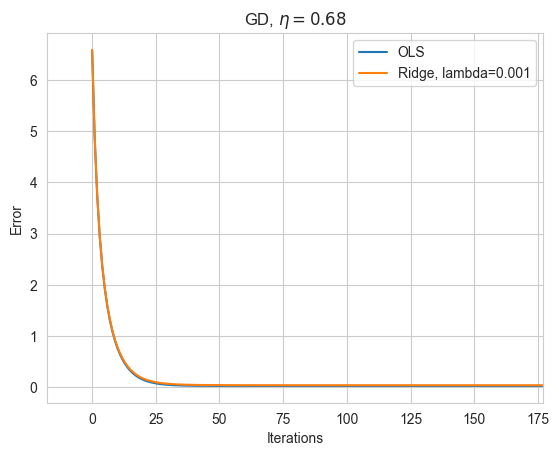

In [246]:
# Parameters
learn_rate = 0.68  # learning rate

# store the theta errors for each iter
errors_gd_ols = np.zeros(N_epoch)
errors_gd_ridge = np.zeros_like(errors_gd_ols)

# begin with theta guess
theta_gd_ols = rng.standard_normal((2, 1))
theta_gd_ridge = theta_gd_ols.copy()

# OLS loop
theta_gd_ols_prev = np.zeros(theta_gd_ols.shape)
for epoch_ols in epoch_iters:
    theta_gd_ols_prev = theta_gd_ols.copy()

    # Plain gradient descent: update theta
    theta_gd_ols -= learn_rate * grad_ols(X, y, theta_gd_ols)

    # Store MSE as error
    errors_gd_ols[epoch_ols] = ols_cost(X, y, theta_gd_ols)

    # Convergence test
    if all(abs(theta_gd_ols - theta_gd_ols_prev) <= theta_tol):
        errors_gd_ols[epoch_ols:] = errors_gd_ols[
            epoch_ols]  # stop iteration and use the last error for the rest of the array
        break

# Ridge loop
theta_gd_ridge_prev = np.zeros(theta_gd_ridge.shape)
for epoch_ridge in epoch_iters:
    theta_gd_ridge_prev = theta_gd_ridge.copy()

    # Plain gradient descent: update theta
    theta_gd_ridge -= learn_rate * grad_ridge(X, y, lmbda, theta_gd_ridge)

    # Store MSE as error
    errors_gd_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_gd_ridge)

    # Convergence test
    if all(abs(theta_gd_ridge - theta_gd_ridge_prev) <= theta_tol):
        errors_gd_ridge[epoch_ridge:] = errors_gd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_gd_ols, label="OLS")
plt.plot(epoch_iters, errors_gd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(f"GD, $\eta={learn_rate:.2f}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_gd_ols.ravel()}, error={errors_gd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
        f"Ridge theta={theta_gd_ridge.ravel()}, error={errors_gd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

The choice of fixed learning rate $\eta=0.68$ gave the fastest convergence with the same error value. This is still below $2/\lambda_{max}=0.77$. 

# 2. Gradient descent with momentum/memory (GDM) with fixed learning rate

OLS theta=[ 4.63898698 -7.93024772], error=2.832e-02, converged after 75 iterations.
Ridge theta=[ 4.56952825 -7.80431773], error=4.200e-02, converged after 74 iterations.


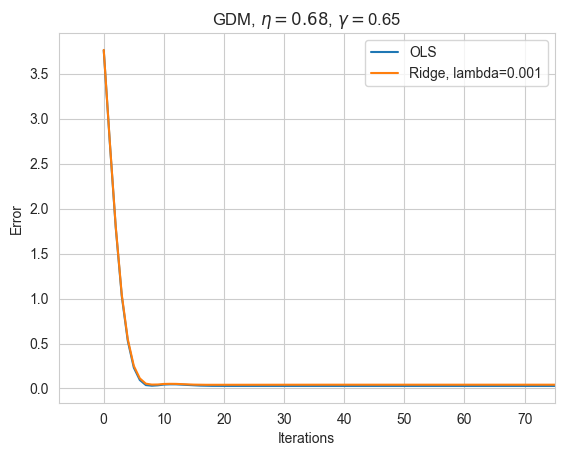

In [247]:
# Parameters
learn_rate = learn_rate  # learning rate, use same as for GD
momentum_rate = 0.65  # momentum rate gamma

# store the theta errors for each iter
errors_gdm_ols = np.zeros(N_epoch)
errors_gdm_ridge = np.zeros_like(errors_gdm_ols)

# begin with theta guess
theta_gdm_ols = rng.standard_normal((2, 1))
theta_gdm_ridge = theta_gdm_ols.copy()

# OLS loop
theta_gdm_ols_prev = np.zeros(theta_gdm_ols.shape)
change = 0
for epoch_ols in epoch_iters:
    theta_gdm_ols_prev = theta_gdm_ols.copy()

    # GDM change 
    new_change = learn_rate * grad_ols(X, y, theta_gdm_ols) + momentum_rate * change

    # Update values
    theta_gdm_ols -= new_change
    change = new_change.copy()

    # Store MSE as error
    errors_gdm_ols[epoch_ols] = ols_cost(X, y, theta_gdm_ols)

    # Convergence test
    if all(abs(theta_gdm_ols - theta_gdm_ols_prev) <= theta_tol):
        errors_gdm_ols[epoch_ols:] = errors_gdm_ols[epoch_ols]
        break

# Ridge loop
theta_gdm_ridge_prev = np.zeros(theta_gdm_ridge.shape)
change = 0
for epoch_ridge in epoch_iters:
    theta_gdm_ridge_prev = theta_gdm_ridge.copy()

    # GDM change 
    new_change = learn_rate * grad_ridge(X, y, lmbda, theta_gdm_ridge) + momentum_rate * change

    # Update values
    theta_gdm_ridge -= new_change
    change = new_change.copy()

    # Store MSE as error
    errors_gdm_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_gdm_ridge)

    # Convergence test
    if all(abs(theta_gdm_ridge - theta_gdm_ridge_prev) <= theta_tol):
        errors_gdm_ridge[epoch_ridge:] = errors_gdm_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_gdm_ols, label="OLS")
plt.plot(epoch_iters, errors_gdm_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(f"GDM, $\eta={learn_rate:.2f}$, $\gamma=${momentum_rate:.2f}")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_gdm_ols.ravel()}, error={errors_gdm_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
        f"Ridge theta={theta_gdm_ridge.ravel()}, error={errors_gdm_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

Clearly using momentum provides a bit faster convergence (ish twice as fast), although (at least for this example) the same error. This choice of momentum rate $\gamma\approx0.65$ gave the fastest convergence. I would think that for other more complex examples adding momentum would be even more beneficial than this was.

# 3. Stochastic gradient descent (SGD) with replacement and scaling learning rate

OLS theta=[ 3.05517463 -5.04878049], error=7.079e-01, converged after 999 epochs.
Ridge theta=[ 3.05517463 -5.04878049], error=7.347e-01, converged after 999 epochs.


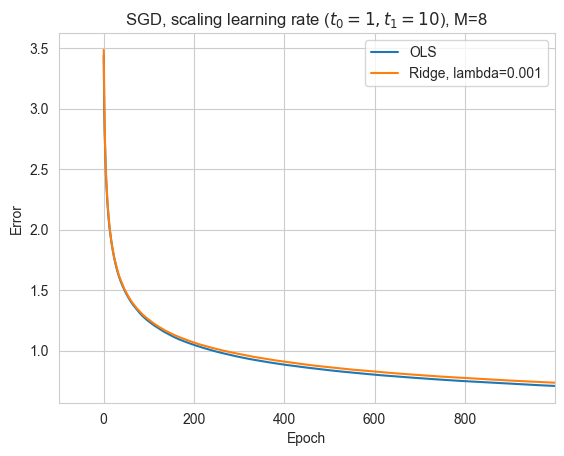

In [248]:
# Parameters
M = 8  # size of each minibatch
m = int(N / M)  # number of minibatches

# Learning schedule parameters
t0 = 1
t1 = 10


def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time."""
    return t0 / (t + t1)


# store the theta errors for each iter
errors_sgd_ols = np.zeros(N_epoch)
errors_sgd_ridge = np.zeros_like(errors_sgd_ols)

# begin with theta guess
theta_sgd_ols = rng.standard_normal((2, 1))
theta_sgd_ridge = theta_sgd_ols.copy()

# OLS loop
theta_sgd_ols_prev = np.zeros(theta_sgd_ols.shape)
for epoch_ols in epoch_iters:
    theta_sgd_ols_prev = theta_sgd_ols.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        # Gradient descent with memory on the random batch
        gradient = grad_ols(Xi, yi, theta_sgd_ols)

        # Update values
        learn_rate_i = learning_schedule(epoch_ols * m + i)
        theta_sgd_ols -= learn_rate_i * gradient

        # Store MSE as error for each epoch iteration
    errors_sgd_ols[epoch_ols] = ols_cost(X, y, theta_sgd_ols)

    # Convergence test
    if all(abs(theta_sgd_ols - theta_sgd_ols_prev) <= theta_tol):
        errors_sgd_ols[epoch_ols:] = errors_sgd_ols[epoch_ols]
        break

# Ridge loop
theta_sgd_ridge_prev = np.zeros(theta_sgd_ridge.shape)
for epoch_ridge in epoch_iters:
    theta_sgd_ridge_prev = theta_sgd_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        # Gradient descent with memory on the random batch
        gradient = grad_ridge(Xi, yi, lmbda, theta_sgd_ridge)

        # Update values
        learn_rate_i = learning_schedule(epoch_ridge * m + i)
        theta_sgd_ridge -= learn_rate_i * gradient

    # Store MSE as error for each epoch iteration
    errors_sgd_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_sgd_ridge)

    # Convergence test
    if all(abs(theta_sgd_ridge - theta_sgd_ridge_prev) <= theta_tol):
        errors_sgd_ridge[epoch_ridge:] = errors_sgd_ridge[epoch_ridge]
        break

# Plot errors as function of epoch iteration
plt.plot(epoch_iters, errors_sgd_ols, label="OLS")
plt.plot(epoch_iters, errors_sgd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title(f"SGD, scaling learning rate ($t_0={t0}, t_1={t1}$), {M=}")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_sgd_ols.ravel()}, error={errors_sgd_ols[-1]:.3e}, converged after {epoch_ols} epochs.")
print(f"Ridge theta={theta_sgd_ols.ravel()}, error={errors_sgd_ridge[-1]:.3e}, converged after {epoch_ridge} epochs.")

Here increasing the hyperparameter $M$ provides much faster runtime, but also provides slower convergence. For some reason I do not get convergence at all with any SDG algorithm. It is probably a bug in my code somewhere. The error is also higher than the previous methods.

# 3. Stochastic gradient descent with momentum (SGDM) with replacement and scaling learning rate

OLS theta=[ 4.60084302 -7.86085739], error=2.872e-02, converged after 999 epochs.
Ridge theta=[ 4.60084302 -7.86085739], error=4.320e-02, converged after 999 epochs.


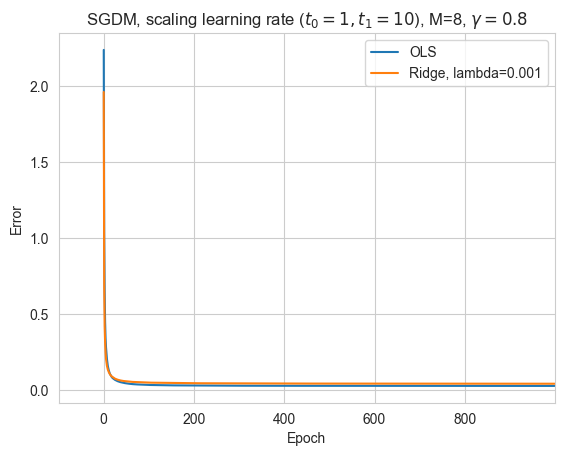

In [249]:
# Parameters
M = 8  # size of each minibatch
m = int(N / M)  # number of minibatches
momentum_rate = 0.8  # momentum rate gamma

# Learning schedule parameters
t0 = 1
t1 = 10


def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time."""
    return t0 / (t + t1)


# store the theta errors for each iter
errors_sgdm_ols = np.zeros(N_epoch)
errors_sgdm_ridge = np.zeros_like(errors_sgdm_ols)

# begin with theta guess
theta_sgdm_ols = rng.standard_normal((2, 1))
theta_sgdm_ridge = theta_sgdm_ols.copy()

# OLS loop
theta_sgdm_ols_prev = np.zeros(theta_sgdm_ols.shape)
change = 0
for epoch_ols in epoch_iters:
    theta_sgdm_ols_prev = theta_sgdm_ols.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        # Gradient descent with memory on the random batch
        gradient = grad_ols(Xi, yi, theta_sgdm_ols)
        learn_rate_i = learning_schedule(epoch_ols * m + i)
        new_change = learn_rate_i * gradient + momentum_rate * change

        # Update values
        theta_sgdm_ols -= new_change
        change = new_change.copy()

    # Store MSE as error for each epoch iteration
    errors_sgdm_ols[epoch_ols] = ols_cost(X, y, theta_sgdm_ols)

    # Convergence test
    if all(abs(theta_sgdm_ols - theta_sgdm_ols_prev) <= theta_tol):
        errors_sgdm_ols[epoch_ols:] = errors_sgdm_ols[epoch_ols]
        break

# Ridge loop
theta_sgdm_ridge_prev = np.zeros(theta_sgdm_ridge.shape)
change = 0
for epoch_ridge in epoch_iters:
    theta_sgdm_ridge_prev = theta_sgdm_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        # Gradient descent with memory on the random batch
        learn_rate_i = learning_schedule(epoch_ridge * m + i)
        gradient = grad_ridge(Xi, yi, lmbda, theta_sgdm_ridge)
        new_change = learn_rate_i * gradient + momentum_rate * change

        # Update values
        theta_sgdm_ridge -= new_change
        change = new_change.copy()

    # Store MSE as error for each epoch iteration
    errors_sgdm_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_sgdm_ridge)

    # Convergence test
    if all(abs(theta_sgdm_ridge - theta_sgdm_ridge_prev) <= theta_tol):
        errors_sgdm_ridge[epoch_ridge:] = errors_sgdm_ridge[epoch_ridge]
        break

# Plot errors as function of epoch iteration
plt.plot(epoch_iters, errors_sgdm_ols, label="OLS")
plt.plot(epoch_iters, errors_sgdm_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title(f"SGDM, scaling learning rate ($t_0={t0}, t_1={t1}$), {M=}, $\gamma={momentum_rate}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_sgdm_ols.ravel()}, error={errors_sgdm_ols[-1]:.3e}, converged after {epoch_ols} epochs.")
print(f"Ridge theta={theta_sgdm_ols.ravel()}, error={errors_sgdm_ridge[-1]:.3e}, converged after {epoch_ridge} epochs.")

As mentioned my SGD code does not converge for some reason. Notably the error dropped extremely fast, and is as low as GD and GDM.

 # 4. Tuning the learning rate with Adagrad

### Adagrad GD

OLS theta=[ 4.63898648 -7.93024688], error=2.832e-02, converged after 212 iterations.
Ridge theta=[ 4.56952786 -7.80431703], error=4.200e-02, converged after 209 iterations.


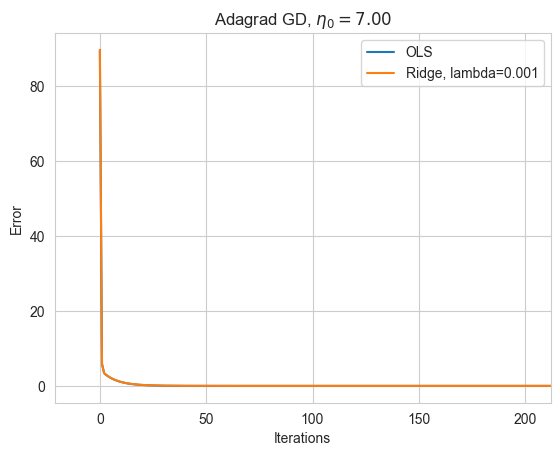

In [269]:
# Parameters
learn_rate = 7  # starting learning rate
delta = 1e-8  # small value for numerical stability  

# store the theta errors for each iter
errors_agd_ols = np.zeros(N_epoch)
errors_agd_ridge = np.zeros_like(errors_agd_ols)

# begin with theta guess
theta_agd_ols = rng.standard_normal((2, 1))
theta_agd_ridge = theta_agd_ols.copy()

# OLS loop
theta_agd_ols_prev = np.zeros(theta_agd_ols.shape)
r = 0
for epoch_ols in epoch_iters:
    theta_agd_ols_prev = theta_agd_ols.copy()

    # Gradient descent
    gradient = grad_ols(X, y, theta_agd_ols)
    r += gradient * gradient
    theta_agd_ols -= learn_rate / (delta + np.sqrt(r)) * gradient  # scale the learning rate with r

    # Store MSE as error
    errors_agd_ols[epoch_ols] = ols_cost(X, y, theta_agd_ols)

    # Convergence test
    if all(abs(theta_agd_ols - theta_agd_ols_prev) <= theta_tol):
        errors_agd_ols[epoch_ols:] = errors_agd_ols[epoch_ols]
        break

# Ridge loop
theta_agd_ridge_prev = np.zeros(theta_agd_ridge.shape)
r = 0
for epoch_ridge in epoch_iters:
    theta_agd_ridge_prev = theta_agd_ridge.copy()

    # Gradient descent: update theta
    gradient = grad_ridge(X, y, lmbda, theta_agd_ridge)
    r += gradient * gradient
    theta_agd_ridge -= learn_rate / (delta + np.sqrt(r)) * gradient  # scale the learning rate with r

    # Store MSE as error
    errors_agd_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_agd_ridge)

    # Convergence test
    if all(abs(theta_agd_ridge - theta_agd_ridge_prev) <= theta_tol):
        errors_agd_ridge[epoch_ridge:] = errors_agd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_agd_ols, label="OLS")
plt.plot(epoch_iters, errors_agd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(f"Adagrad GD, $\eta_0={learn_rate:.2f}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_agd_ols.ravel()}, error={errors_agd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
    f"Ridge theta={theta_agd_ridge.ravel()}, error={errors_agd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

The convergence varies from each run to run between around $150$ to $280$ epochs, but the overall best starting learning rate $\eta_0\approx 7$ was the fastest to converge. Overall this seems to converge slower than previous methods.

### Adagrad GDM

OLS theta=[ 4.63898692 -7.93024765], error=2.832e-02, converged after 108 iterations.
Ridge theta=[ 4.56952825 -7.80431771], error=2.962e-02, converged after 105 iterations.


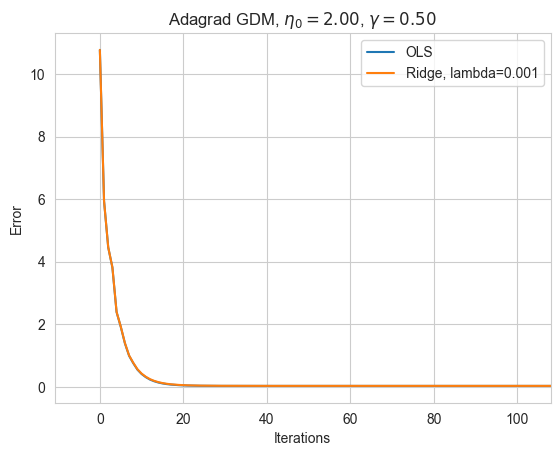

In [251]:
# Parameters
learn_rate = 2  # starting learning rate
momentum_rate = 0.5  # momentum rate gamma
delta = delta  # small value for numerical stability  

# store the theta errors for each iter
errors_agdm_ols = np.zeros(N_epoch)
errors_agdm_ridge = np.zeros_like(errors_agdm_ols)

# begin with theta guess
theta_agdm_ols = rng.standard_normal((2, 1))
theta_agdm_ridge = theta_agdm_ols.copy()

# OLS loop
theta_agdm_ols_prev = np.zeros(theta_agdm_ols.shape)
r = 0
change = 0
for epoch_ols in epoch_iters:
    theta_agdm_ols_prev = theta_agdm_ols.copy()

    # GDM
    gradient = grad_ols(X, y, theta_agdm_ols)
    r += gradient * gradient
    new_change = learn_rate / (delta + np.sqrt(r)) * gradient + momentum_rate * change  # scale the learning rate with r
    theta_agdm_ols -= new_change

    # Store MSE as error
    errors_agdm_ols[epoch_ols] = ols_cost(X, y, theta_agdm_ols)

    change = new_change.copy()

    # Convergence test
    if all(abs(theta_agdm_ols - theta_agdm_ols_prev) <= theta_tol):
        errors_agdm_ols[epoch_ols:] = errors_agdm_ols[epoch_ols]
        break

# Ridge loop
theta_agdm_ridge_prev = np.zeros(theta_agdm_ridge.shape)
r = 0
change = 0
for epoch_ridge in epoch_iters:
    theta_agdm_ridge_prev = theta_agdm_ridge.copy()

    # GDM
    gradient = grad_ridge(X, y, lmbda, theta_agdm_ridge)
    r += gradient * gradient
    new_change = learn_rate / (delta + np.sqrt(r)) * gradient + momentum_rate * change  # scale the learning rate with r
    theta_agdm_ridge -= new_change

    # Store MSE as error
    errors_agdm_ridge[epoch_ridge] = ols_cost(X, y, theta_agdm_ridge)

    change = new_change.copy()

    # Convergence test
    if all(abs(theta_agdm_ridge - theta_agdm_ridge_prev) <= theta_tol):
        errors_agdm_ridge[epoch_ridge:] = errors_agdm_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_agdm_ols, label="OLS")
plt.plot(epoch_iters, errors_agdm_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(f"Adagrad GDM, $\eta_0={learn_rate:.2f}$, $\gamma={momentum_rate:.2f}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_agdm_ols.ravel()}, error={errors_agdm_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
        f"Ridge theta={theta_agdm_ridge.ravel()}, error={errors_agdm_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

This is of course, again, faster than Adagrad GD without momentum, it converges faster by ish 2.5 times depending on the run. Comparing with GDM its only slightly (around 1.5 times) faster.

### Adagrad SGD

OLS theta=[ 4.60538165 -7.93308053], error=2.955e-02, converged after 999 iterations.
Ridge theta=[ 4.55630177 -7.79594074], error=4.231e-02, converged after 999 iterations.


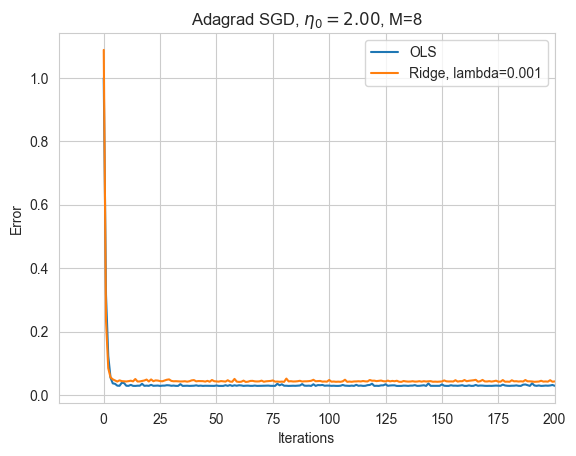

In [272]:
# Parameters
M = 8  # size of each minibatch
m = int(N / M)  # number of minibatches
learn_rate = 2  # starting learning rate
delta = delta  # small value for numerical stability  

# store the theta errors for each iter
errors_asgd_ols = np.zeros(N_epoch)
errors_asgd_ridge = np.zeros_like(errors_asgd_ols)

# begin with theta guess
theta_asgd_ols = rng.standard_normal((2, 1))
theta_asgd_ridge = theta_asgd_ols.copy()

# OLS loop
theta_asgd_ols_prev = np.zeros(theta_asgd_ols.shape)
r = 0
for epoch_ols in epoch_iters:
    theta_asgd_ols_prev = theta_asgd_ols.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        gradient = grad_ols(Xi, yi, theta_asgd_ols)
        r += gradient * gradient

        # Update theta
        theta_asgd_ols -= learn_rate / (delta + np.sqrt(r)) * gradient  # scale learning rate with r

    # Store MSE as error
    errors_asgd_ols[epoch_ols] = ols_cost(X, y, theta_asgd_ols)

    # Convergence test
    if all(abs(theta_asgd_ols - theta_asgd_ols_prev) <= theta_tol):
        errors_asgd_ols[epoch_ols:] = errors_asgd_ols[epoch_ols]
        break

# Ridge loop
theta_asgd_ridge_prev = np.zeros(theta_asgd_ridge.shape)
r = 0
for epoch_ridge in epoch_iters:
    theta_asgd_ridge_prev = theta_asgd_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        gradient = grad_ridge(Xi, yi, lmbda, theta_asgd_ridge)
        r += gradient * gradient

        # Update theta
        theta_asgd_ridge -= learn_rate / (delta + np.sqrt(r)) * gradient  # scale learning rate with r

    # Store MSE as error
    errors_asgd_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_asgd_ridge)

    # Convergence test
    if all(abs(theta_asgd_ridge - theta_asgd_ridge_prev) <= theta_tol):
        errors_asgd_ridge[epoch_ridge:] = errors_asgd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_asgd_ols, label="OLS")
plt.plot(epoch_iters, errors_asgd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(f"Adagrad SGD, $\eta_0={learn_rate:.2f}$, {M=}")
plt.xlim(-0.1 * 200, 200)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_asgd_ols.ravel()}, error={errors_asgd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
    f"Ridge theta={theta_asgd_ridge.ravel()}, error={errors_asgd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

Still no convergence in my SDG code, but we see the error drops extremely fast using Adagrad

### Adagrad SGDM

OLS theta=[ 4.56635141 -7.83803982], error=2.964e-02, converged after 999 iterations.
Ridge theta=[ 4.66737053 -7.86296784], error=4.519e-02, converged after 999 iterations.


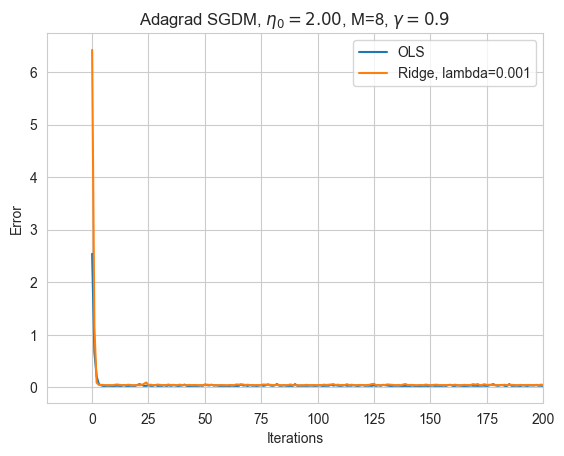

In [257]:
# Parameters
M = 8  # size of each minibatch
m = int(N / M)  # number of minibatches
learn_rate = 2  # starting learning rate
momentum_rate = 0.9  # momentum rate gamma
delta = delta  # small value for numerical stability  

# store the theta errors for each iter
errors_asgd_ols = np.zeros(N_epoch)
errors_asgd_ridge = np.zeros_like(errors_asgd_ols)

# begin with theta guess
theta_asgd_ols = rng.standard_normal((2, 1))
theta_asgd_ridge = theta_asgd_ols.copy()

# OLS loop
theta_asgd_ols_prev = np.zeros(theta_asgd_ols.shape)
r = 0
change = 0
for epoch_ols in epoch_iters:
    theta_asgd_ols_prev = theta_asgd_ols.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        gradient = grad_ols(Xi, yi, theta_asgd_ols)
        r += gradient * gradient
        new_change = learn_rate / (delta + np.sqrt(r)) * gradient + momentum_rate * change  # scale learning rate with r

        # Update values
        theta_asgd_ols -= new_change
        change = new_change.copy()

    # Store MSE as error
    errors_asgd_ols[epoch_ols] = ols_cost(X, y, theta_asgd_ols)

    # Convergence test
    if all(abs(theta_asgd_ols - theta_asgd_ols_prev) <= theta_tol):
        errors_asgd_ols[epoch_ols:] = errors_asgd_ols[epoch_ols]
        break

# Ridge loop
theta_asgd_ridge_prev = np.zeros(theta_asgd_ridge.shape)
r = 0
change = 0
for epoch_ridge in epoch_iters:
    theta_asgd_ridge_prev = theta_asgd_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        gradient = grad_ridge(Xi, yi, lmbda, theta_asgd_ridge)
        r += gradient * gradient
        new_change = learn_rate / (delta + np.sqrt(r)) * gradient + momentum_rate * change  # scale learning rate with r

        # Update values
        theta_asgd_ridge -= new_change
        change = new_change.copy()

    # Store MSE as error
    errors_asgd_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_asgd_ridge)

    # Convergence test
    if all(abs(theta_asgd_ridge - theta_asgd_ridge_prev) <= theta_tol):
        errors_asgd_ridge[epoch_ridge:] = errors_asgd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_asgd_ols, label="OLS")
plt.plot(epoch_iters, errors_asgd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(f"Adagrad SGDM, $\eta_0={learn_rate:.2f}$, {M=}, $\gamma={momentum_rate}$")
plt.xlim(-0.1 * 200, 200)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_asgd_ols.ravel()}, error={errors_asgd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
        f"Ridge theta={theta_asgd_ridge.ravel()}, error={errors_asgd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

# 5. Tuning the learning rate with RMSProp 
### RMSProp SDG

OLS theta=[ 4.59067248 -7.94297784], error=3.135e-02, converged after 999 iterations.
Ridge theta=[ 4.57688648 -7.81426538], error=4.180e-02, converged after 999 iterations.


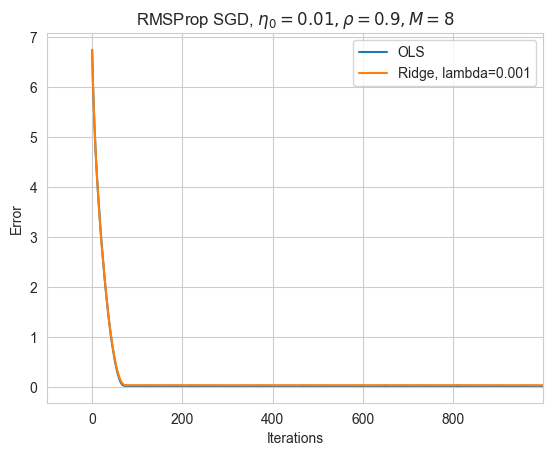

In [289]:
# Parameters
M = 8  # size of each minibatch
m = int(N / M)  # number of minibatches
learn_rate = 0.01  # starting learning rate
rho = 0.9  # rmsprop decay rate rho 
delta = delta  # small value for numerical stability  

# store the theta errors for each iter
errors_rsgd_ols = np.zeros(N_epoch)
errors_rsgd_ridge = np.zeros_like(errors_rsgd_ols)

# begin with theta guess
theta_rsgd_ols = rng.standard_normal((2, 1))
theta_rsgd_ridge = theta_rsgd_ols.copy()

# OLS loop
theta_rsgd_ols_prev = np.zeros(theta_rsgd_ols.shape)
r = 0
for epoch_ols in epoch_iters:
    theta_rsgd_ols_prev = theta_rsgd_ols.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        gradient = grad_ols(Xi, yi, theta_rsgd_ols)
        r = r * rho + (1 - rho) * gradient * gradient

        # Update theta
        theta_rsgd_ols -= learn_rate / (delta + np.sqrt(r)) * gradient  # scale learning rate with r

    # Store MSE as error
    errors_rsgd_ols[epoch_ols] = ols_cost(X, y, theta_rsgd_ols)

    # Convergence test
    if all(abs(theta_rsgd_ols - theta_rsgd_ols_prev) <= theta_tol):
        errors_rsgd_ols[epoch_ols:] = errors_rsgd_ols[epoch_ols]
        break

# Ridge loop
theta_rsgd_ridge_prev = np.zeros(theta_rsgd_ridge.shape)
r = 0
for epoch_ridge in epoch_iters:
    theta_rsgd_ridge_prev = theta_rsgd_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        gradient = grad_ridge(Xi, yi, lmbda, theta_rsgd_ridge)
        r = r * rho + (1 - rho) * gradient * gradient

        # Update theta
        theta_rsgd_ridge -= learn_rate / (delta + np.sqrt(r)) * gradient  # scale learning rate with r

    # Store MSE as error
    errors_rsgd_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_rsgd_ridge)

    # Convergence test
    if all(abs(theta_rsgd_ridge - theta_rsgd_ridge_prev) <= theta_tol):
        errors_rsgd_ridge[epoch_ridge:] = errors_rsgd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_rsgd_ols, label="OLS")
plt.plot(epoch_iters, errors_rsgd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(rf"RMSProp SGD, $\eta_0={learn_rate:.2f}, \rho={rho}, {M=}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_rsgd_ols.ravel()}, error={errors_rsgd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
    f"Ridge theta={theta_rsgd_ridge.ravel()}, error={errors_rsgd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

### RMSProp SDGM

OLS theta=[ 4.67805176 -7.88233685], error=3.257e-02, converged after 999 iterations.
Ridge theta=[ 4.63958863 -7.82627241], error=4.460e-02, converged after 999 iterations.


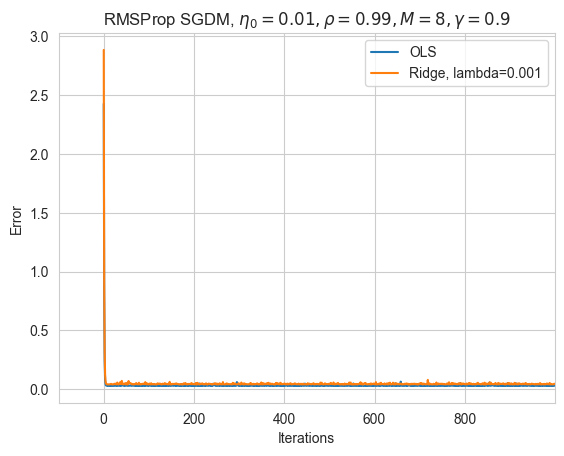

In [288]:
# Parameters
M = 8  # size of each minibatch
m = int(N / M)  # number of minibatches
learn_rate = 0.01  # starting learning rate
rho = 0.99  # rmsprop decay rate rho 
momentum_rate = 0.9  # momentum rate gamma
delta = delta  # small value for numerical stability  

# store the theta errors for each iter
errors_rsgdm_ols = np.zeros(N_epoch)
errors_rsgdm_ridge = np.zeros_like(errors_rsgdm_ols)

# begin with theta guess
theta_rsgdm_ols = rng.standard_normal((2, 1))
theta_rsgdm_ridge = theta_rsgdm_ols.copy()

# OLS loop
theta_rsgdm_ols_prev = np.zeros(theta_rsgdm_ols.shape)
r = 0
change = 0
for epoch_ols in epoch_iters:
    theta_rsgdm_ols_prev = theta_rsgdm_ols.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        gradient = grad_ols(Xi, yi, theta_rsgdm_ols)
        r = r * rho + (1 - rho) * gradient * gradient
        new_change = learn_rate / (delta + np.sqrt(r)) * gradient + momentum_rate * change  # scale learning rate with r

        # Update values
        theta_rsgdm_ols -= new_change
        change = new_change.copy()

    # Store MSE as error
    errors_rsgdm_ols[epoch_ols] = ols_cost(X, y, theta_rsgdm_ols)

    # Convergence test
    if all(abs(theta_rsgdm_ols - theta_rsgdm_ols_prev) <= theta_tol):
        errors_rsgdm_ols[epoch_ols:] = errors_rsgdm_ols[epoch_ols]
        break

# Ridge loop
theta_rsgdm_ridge_prev = np.zeros(theta_rsgdm_ridge.shape)
r = 0
change = 0
for epoch_ridge in epoch_iters:
    theta_rsgdm_ridge_prev = theta_rsgdm_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]

        gradient = grad_ridge(Xi, yi, lmbda, theta_rsgdm_ridge)
        r = r * rho + (1 - rho) * gradient * gradient
        new_change = learn_rate / (delta + np.sqrt(r)) * gradient + momentum_rate * change  # scale learning rate with r

        # Update values
        theta_rsgdm_ridge -= new_change
        change = new_change.copy()

    # Store MSE as error
    errors_rsgdm_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_rsgdm_ridge)

    # Convergence test
    if all(abs(theta_rsgdm_ridge - theta_rsgdm_ridge_prev) <= theta_tol):
        errors_rsgdm_ridge[epoch_ridge:] = errors_rsgdm_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_rsgdm_ols, label="OLS")
plt.plot(epoch_iters, errors_rsgdm_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(rf"RMSProp SGDM, $\eta_0={learn_rate:.2f}, \rho={rho}, {M=}, \gamma={momentum_rate}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_rsgdm_ols.ravel()}, error={errors_rsgdm_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
    f"Ridge theta={theta_rsgdm_ridge.ravel()}, error={errors_rsgdm_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

# 5) ADAM 
### ADAM SGD

OLS theta=[ 4.52233343 -7.71252181], error=3.217e-02, converged after 999 iterations.
Ridge theta=[ 4.56501863 -7.7199912 ], error=4.536e-02, converged after 999 iterations.


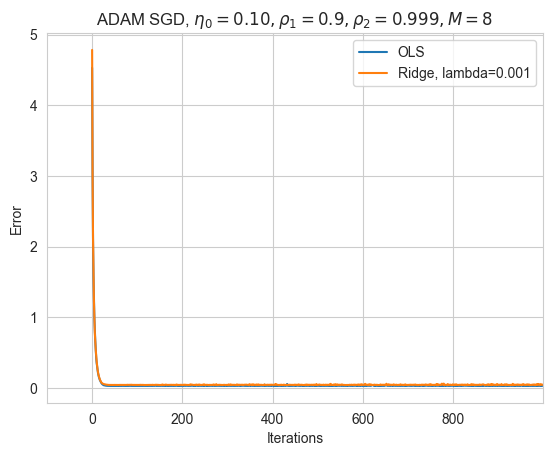

In [286]:
# Parameters
M = 8  # size of each minibatch
m = int(N / M)  # number of minibatches
learn_rate = 0.1  # starting learning rate / step size for ADAM
rho1 = 0.9  # adam decay rate rho_1
rho2 = 0.999  # adam decay rate rho_2 
delta = delta  # small value for numerical stability  

# store the theta errors for each iter
errors_rsgd_ols = np.zeros(N_epoch)
errors_rsgd_ridge = np.zeros_like(errors_rsgd_ols)

# begin with theta guess
theta_rsgd_ols = rng.standard_normal((2, 1))
theta_rsgd_ridge = theta_rsgd_ols.copy()

# OLS loop
theta_rsgd_ols_prev = np.zeros(theta_rsgd_ols.shape)
moment1 = 0
moment2 = 0
for epoch_ols in epoch_iters:
    theta_rsgd_ols_prev = theta_rsgd_ols.copy()
    
    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]
        
        # Calculate gradient
        gradient = grad_ols(Xi, yi, theta_rsgd_ols)
        
        # Update moments
        moment1 = rho1 * moment1 + (1 - rho1) * gradient
        moment2 = rho2 * moment2 + (1 - rho2) * gradient * gradient
        
        # Correct moment bias'
        term1 = moment1/(1 - rho1**(epoch_ols+1))
        term2 = moment2/(1 - rho2**(epoch_ols+1))

        # Update theta
        theta_rsgd_ols -= learn_rate*term1 / (delta + np.sqrt(term2))  # scale learning rate with r

    # Store MSE as error
    errors_rsgd_ols[epoch_ols] = ols_cost(X, y, theta_rsgd_ols)

    # Convergence test
    if all(abs(theta_rsgd_ols - theta_rsgd_ols_prev) <= theta_tol):
        errors_rsgd_ols[epoch_ols:] = errors_rsgd_ols[epoch_ols]
        break

# Ridge loop
theta_rsgd_ridge_prev = np.zeros(theta_rsgd_ridge.shape)
moment1 = 0
moment2 = 0
for epoch_ridge in epoch_iters:
    theta_rsgd_ridge_prev = theta_rsgd_ridge.copy()

    # Iterate through all minibatches for each epoch iteration
    for i in range(m):
        # Pick a minibatch at random from the data set 
        random_index = M * rng.integers(m)
        Xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]
        
        # Calculate gradient
        gradient = grad_ridge(Xi, yi, lmbda, theta_rsgd_ridge)
        
        # Update moments
        moment1 = rho1 * moment1 + (1 - rho1) * gradient
        moment2 = rho2 * moment2 + (1 - rho2) * gradient * gradient
        
        # Correct moment bias'
        term1 = moment1/(1 - rho1**(epoch_ridge+1))
        term2 = moment2/(1 - rho2**(epoch_ridge+1))

        # Update theta
        theta_rsgd_ridge -= learn_rate*term1 / (delta + np.sqrt(term2))  # scale learning rate with r

    # Store MSE as error
    errors_rsgd_ridge[epoch_ridge] = ridge_cost(X, y, lmbda, theta_rsgd_ridge)

    # Convergence test
    if all(abs(theta_rsgd_ridge - theta_rsgd_ridge_prev) <= theta_tol):
        errors_rsgd_ridge[epoch_ridge:] = errors_rsgd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_rsgd_ols, label="OLS")
plt.plot(epoch_iters, errors_rsgd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title(rf"ADAM SGD, $\eta_0={learn_rate:.2f}, \rho_1={rho1}, \rho_2={rho2}, {M=}$")
plt.xlim(-0.1 * epoch_ols, epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_rsgd_ols.ravel()}, error={errors_rsgd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(
    f"Ridge theta={theta_rsgd_ridge.ravel()}, error={errors_rsgd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

# Studying Ridge as function of fixed learning rate $\eta$ and shrinkage $\lambda$
I will here be plotting the plain gradient descent error as function of both of these parameters using the seaborn package.

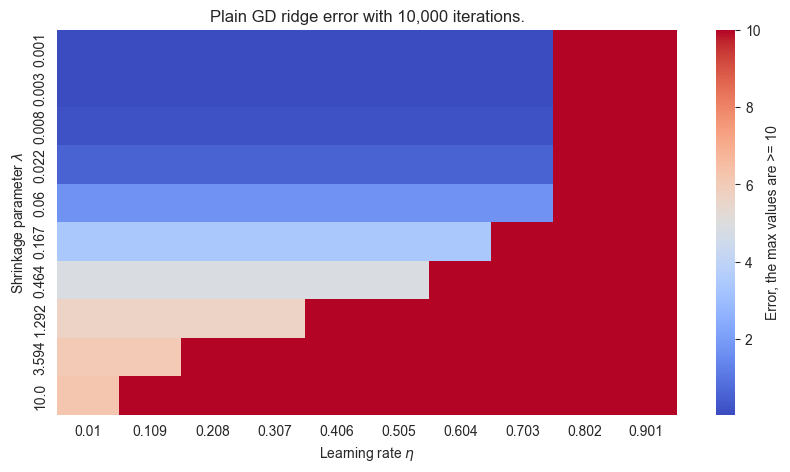

In [365]:
# Parameters
n_iters = 10000  # max no. iterations
ridge_lambdas = np.logspace(-3, 1, 10)  # lambda vals to plot
learn_rates = np.linspace(0.01, 1, 10, endpoint=False)
heatmap_cmap = "coolwarm"  # colormap for seaborn heatmap plots
zmax = 10  # max error value for the colorbar 

errors = np.zeros((learn_rates.size, ridge_lambdas.size))  # store the theta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    
    # Iterate through each learning rate 
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        theta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        
        for iter in range(n_iters):
            theta_prev = theta.copy()

            # Update ridge theta using GD
            grad = grad_ridge(X, y, lmbda, theta)
            theta -= learn_rate * grad

            # Overflow test: stop if theta is blowing up -> will overflow
            if any(theta >= 1e8):
                break
            
            # Convergence test
            if all(abs(theta - theta_prev) <= theta_tol):
                break
            
        # For each learning rate and each lambda store the error
        errors[i, j] = ridge_cost(X, y, lmbda, theta)

# Heatmap plotting
plt.figure(figsize=(10, 5))
round = 3
xticks = np.round(learn_rates, round)
ax = sb.heatmap(
        errors.T,
        annot=False,
        cmap=heatmap_cmap,
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, round), 
        vmax=zmax,  # max cbar value
        cbar_kws={"label": f"Error, the max values are >= {zmax}"}  # colorbar label
)

plt.title(f"Plain GD ridge error with {n_iters:,} iterations.")
plt.xlabel("Learning rate $\eta$")
plt.ylabel("Shrinkage parameter $\lambda$");

NOTE: the red values are $\ge 10$ not necessarily $=10$. These are overflowing error values which see see showing up diagonally as the learning rate increases. This is probably because the learning rate exceeded $2/eig_{max}$ with the current parameter $\lambda$, where $eig_{max}$ is the maximum eigenvalue of the Ridge's Hessian matrix. Other than these overflowing errors we see that the error is basically independent of the learning rate. 